In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers import Flatten, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
file1 = r'/gdrive/MyDrive/Colab Notebooks/datasets/sar_30.csv'
file2 = r'/gdrive/MyDrive/Colab Notebooks/datasets/reg_30.csv'
data_1 = pd.read_csv(file1)
data_2 = pd.read_csv(file2)
data =  pd.concat([data_1, data_2])
data

,date_time,tweet,splchar1,splchar2,is_sarcastic
0,30-04-2021 06:34,b'It\'s said that #sarcasm is the lowest form ...,b'MyWitsEndTweet',b'',1
1,30-04-2021 06:32,b'Praise Be. Thank you @BorisJohnson to allow ...,b'LibertyLins',b'Gilead. ',1
2,30-04-2021 06:24,b'Oh no! Please do not tarnish the impeccable ...,b'NamBiz',"b'Seattle, WA'",1
3,30-04-2021 06:22,b'When someone says :- \nThey said this \nI He...,b'ANSHULV91050396',b'HARYANA VASI ',1
4,30-04-2021 06:17,b'tag that friend \n#dealswalebhaiya #sarcasm ...,b'dealswalebhaiya',b'',1
...,...,...,...,...,...
67,23-04-2021 21:15,b'Regular expressions - I have just completed ...,b'MarcusChachuls1',b'127.0.0.1/Germany',0
68,23-04-2021 14:55,b'\xe0\xb2\xa8\xe0\xb2\xbf\xe0\xb2\x9c \xe0\xb...,b'ImwithVijayEsh1',b'',0
69,23-04-2021 10:48,b'@thegame Hell nah if she ain\xe2\x80\x99t fu...,b'cakes_npies',"b'Amsterdam, The Netherlands'",0
70,23-04-2021 08:55,b'@AskAnshul @Sam4delhi Any news of @ThePrintI...,b'CaptAssamRegt',b'Bhubaneswar ',0


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"b'", "", text)
    text = re.sub(r'b"', '', text)
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!#@$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [ ]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    tweets = list()
    lines = df["tweet"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        tweets.append(words)
    return tweets

tweets = CleanTokenize(data)
tweets[0:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[['said',
  'sarcasm',
  'lowest',
  'form',
  'wit',
  'say',
  'really',
  'hey',
  'somebody',
  'give',
  'person',
  'nobel',
  'peace',
  'prize'],
 ['praise', 'thank', 'allow', 'hug', 'family', 'grateful', 'dystopia'],
 ['oh', 'please', 'tarnish', 'impeccable', 'name', 'ec', 'sarcasm'],
 ['someone',
  'says',
  'nthey',
  'said',
  'ni',
  'heard',
  'nnme',
  'dude',
  'need',
  'hearing',
  'machine',
  'think'],
 ['tag',
  'friend',
  'ndealswalebhaiya',
  'sarcasm',
  'indianmemes',
  'backchodi',
  'tvf',
  'tvforiginal',
  'aspirants'],
 ['besides', 'antinational', 'termed', 'inhumane', 'wellnsarcasm'],
 ['somewhat', 'savage'],
 ['found', 'swara', 'bhaskars', 'native', 'place'],
 ['said',
  'sarcasm',
  'lowest',
  'form',
  'wit',
  'say',
  'really',
  'hey',
  'somebody',
  'give',
  'person',
  'nobel',
  'peace',
  'prize'],
 ['friend',
  'sarcastic',
  'timenme',
  'sarcasm',
  'keeps',
  'alive',
  'tell',
  'quitennsarcasm']]

(-0.5, 999.5, 499.5, -0.5)

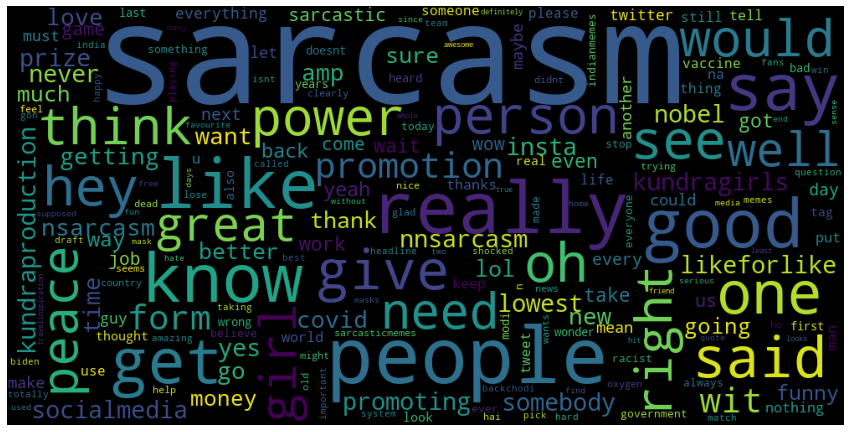

In [ ]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [ ]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  5042
vocab size - 5043


In [ ]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (1351, 25)
Shape of y_train: (1351,)
Shape of X_test_pad: (337, 25)
Shape of y_test: (337,)


In [ ]:
embeddings_index = {}
embedding_dim = 100
f = open(os.path.join('','/gdrive/MyDrive/Colab Notebooks/datasets/glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

4232


In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

**RNN NETWORK**

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           504300    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 546,605
Trainable params: 42,305
Non-trainable params: 504,300
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/25
43/43 - 5s - loss: 0.3104 - acc: 0.9393 - val_loss: 0.1064 - val_acc: 0.9822
Epoch 2/25
43/43 - 1s - loss: 0.1359 - acc: 0.9689 - val_loss: 0.0828 - val_acc: 0.9822
Epoch 3/25
43/43 - 1s - loss: 0.1184 - acc: 0.9682 - val_loss: 0.1033 - val_acc: 0.9585
Epoch 4/25
43/43 - 1s - loss: 0.0894 - acc: 0.9778 - val_loss: 0.0909 - val_acc: 0.9674
Epoch 5/25
43/43 - 1s - loss: 0.0692 - acc: 0.9822 - val_loss: 0.0769 - val_acc: 0.9792
Epoch 6/25
43/43 - 1s - loss: 0.0521 - acc: 0.9889 - val_loss: 0.0747 - val_acc: 0.9822
Epoch 7/25
43/43 - 1s - loss: 0.0508 - acc: 0.9889 - val_loss: 0.0705 - val_acc: 0.9822
Epoch 8/25
43/43 - 1s - loss: 0.0457 - acc: 0.9911 - val_loss: 0.0773 - val_acc: 0.9822
Epoch 9/25
43/43 - 1s - loss: 0.0461 - acc: 0.9889 - val_loss: 0.1223 - val_acc: 0.9644
Epoch 10/25
43/43 - 1s - loss: 0.0435 - acc: 0.9904 - val_loss: 0.0714 - val_acc: 0.9852
Epoch 11/25
43/43 - 1s - loss: 0.0448 - acc: 0.9911 - val_loss: 0.0756 - val_acc: 0.9852
Epoch 12/25
43/43 - 1s - loss:

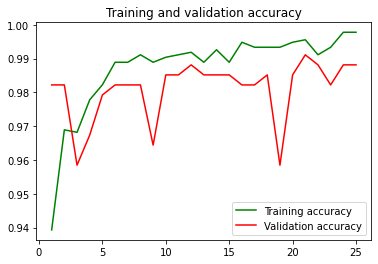

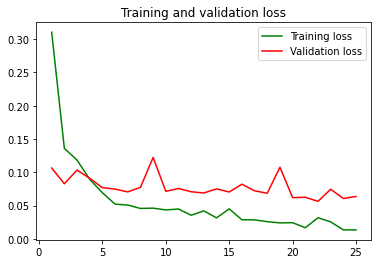

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**VALIDATION LOSS AND ACCURACY OF RNN**


In [ ]:
validation_acc_rnn = val_acc[-1]
validation_loss_rnn = val_loss[-1]
print("validation_loss: %.2f%%" % (validation_loss_rnn*100))
print("validation_Accuracy: %.2f%%" % (validation_acc_rnn*100))


validation_loss: 6.36%
validation_Accuracy: 98.81%


**TRAINING LOSS AND ACCCURACY OF RNN**

In [ ]:
training_loss_rnn = loss[-1]
training_acc_rnn = acc[-1]
print("training_loss: %.2f%%" % (training_loss_rnn*100))
print("training_Accuracy: %.2f%%" % (training_acc_rnn*100))

training_loss: 1.34%
training_Accuracy: 99.78%


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

**TRAINING PERFORMANCE METRICS**

In [ ]:
yhat_classes = model.predict_classes(X_train_pad, verbose=2)

In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_train, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, yhat_classes)
print('F1 score: %f' % f1)

Precision: 0.998453
Recall: 1.000000
F1 score: 0.999226


In [ ]:
matrix = confusion_matrix(y_train, yhat_classes)
print(matrix)

[[  58    2]
 [   0 1291]]


**VALIDATION PERFORMANCE METRICS**

In [ ]:
yhat_class = model.predict_classes(X_test_pad, verbose=2,batch_size=32)

In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_class)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_class)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_class)
print('F1 score: %f' % f1)

Precision: 0.990826
Recall: 0.996923
F1 score: 0.993865


In [ ]:
matrix = confusion_matrix(y_test, yhat_class)
print(matrix)

[[  9   3]
 [  1 324]]


**PLOT OF RNN**

**CNN NETWORK**


In [ ]:
model_conv = Sequential()
model_conv.add(embedding_layer)
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Summary of the built model...')
print(model_conv.summary())

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           504300    
_________________________________________________________________
dropout (Dropout)            (None, 25, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 602,465
Trainable params: 98,165
Non-trainable params: 504,300
_____________

In [ ]:
hist = model_conv.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/25
43/43 - 3s - loss: 0.2477 - accuracy: 0.9548 - val_loss: 0.1235 - val_accuracy: 0.9674
Epoch 2/25
43/43 - 1s - loss: 0.1241 - accuracy: 0.9682 - val_loss: 0.1126 - val_accuracy: 0.9644
Epoch 3/25
43/43 - 1s - loss: 0.0856 - accuracy: 0.9741 - val_loss: 0.0790 - val_accuracy: 0.9733
Epoch 4/25
43/43 - 1s - loss: 0.0526 - accuracy: 0.9837 - val_loss: 0.0680 - val_accuracy: 0.9792
Epoch 5/25
43/43 - 1s - loss: 0.0369 - accuracy: 0.9904 - val_loss: 0.0700 - val_accuracy: 0.9792
Epoch 6/25
43/43 - 1s - loss: 0.0212 - accuracy: 0.9956 - val_loss: 0.0672 - val_accuracy: 0.9852
Epoch 7/25
43/43 - 1s - loss: 0.0141 - accuracy: 0.9963 - val_loss: 0.0906 - val_accuracy: 0.9733
Epoch 8/25
43/43 - 1s - loss: 0.0191 - accuracy: 0.9948 - val_loss: 0.0601 - val_accuracy: 0.9911
Epoch 9/25
43/43 - 1s - loss: 0.0138 - accuracy: 0.9963 - val_loss: 0.1759 - val_accuracy: 0.9377
Epoch 10/25
43/43 - 1s - loss: 0.0257 - accuracy: 0.9926 - val_loss: 0.0659 - val_accuracy: 0.9852
Epoch 11/25
43/43 -

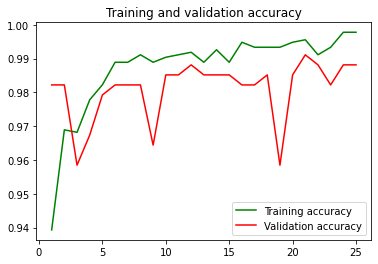

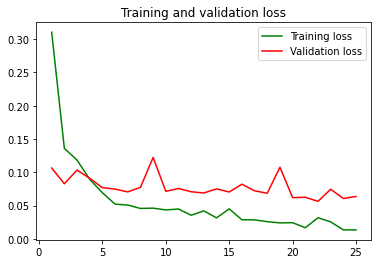

In [ ]:
conv_acc = hist.history['accuracy']
conv_val_acc = hist.history['val_accuracy']
conv_loss = hist.history['loss']
conv_val_loss = hist.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**VALIDATION LOSS AND ACCURACY OF CNN**


In [ ]:
valid_acc_cnn = conv_val_acc[-1]
valid_loss_cnn = conv_val_loss[-1]
print("validation_loss: %.2f%%" % (valid_loss_cnn*100))
print("validation_Accuracy: %.2f%%" % (valid_acc_cnn*100))

validation_loss: 13.43%
validation_Accuracy: 97.03%


**TRAINING LOSS AND ACCURACY OF CNN**

In [ ]:
train_loss_cnn = conv_loss[-1]
train_acc_cnn = conv_acc[-1]
print("training_loss: %.2f%%" % (train_loss_cnn*100))
print("training_Accuracy: %.2f%%" % (train_acc_cnn*100))

training_loss: 0.51%
training_Accuracy: 99.85%


**TRAINING PERFORMANCE METRICS**

In [ ]:
yhat_cls = model_conv.predict_classes(X_train_pad, verbose=2)

In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_train, yhat_cls)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, yhat_cls)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, yhat_cls)
print('F1 score: %f' % f1)

Precision: 0.999224
Recall: 0.997676
F1 score: 0.998450


In [ ]:
matrix = confusion_matrix(y_train, yhat_cls)
print(matrix)

[[  59    1]
 [   3 1288]]


**VALIDATION PERFORMANCE METRICS**

In [ ]:
yhat_clsses = model_conv.predict_classes(X_test_pad, verbose=2)

In [ ]:

# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_clsses)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_clsses)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_clsses)
print('F1 score: %f' % f1)

Precision: 0.990654
Recall: 0.978462
F1 score: 0.984520


In [ ]:
matrix = confusion_matrix(y_test, yhat_clsses)
print(matrix)

[[  9   3]
 [  7 318]]


**PLOT FOR CNN**

**TESTING**


In [ ]:
def predict_sarcasm_rnn(s):
    print(s)
    x_final = pd.DataFrame({"tweet":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: print("It's a sarcasm!") 
    else: print("It's not a sarcasm.")

In [ ]:
def predict_sarcasm_cnn(s):
    print(s)
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model_conv.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: print("It's a sarcasm!") 
    else: print("It's not a sarcasm.")

In [ ]:
import csv  


In [ ]:
with open('/gdrive/MyDrive/Colab Notebooks/datasets/predict_headlines.txt','r') as csv_file: #Opens the file in read mode
        for line in csv_file:
            predict_sarcasm_rnn(line)

I was depressed. He asked me to be happy. I am not depressed anymore.

It's a sarcasm!
You just broke my car window. Great job.

It's a sarcasm!
You just saved my dog's life. Thanks a million.

It's a sarcasm!
I want a million dollars!
It's a sarcasm!


**COMPARISON**

In [ ]:
if ( training_acc_rnn > train_acc_cnn ):
     st = "RNN IS BETTER COMPARED TO CNN by comparing training accuracy"
     print(st)

else:
     st="CNN IS BETTEER COMPARED TO RNN by comparing training accuracy"
     print(st)


CNN IS BETTEER COMPARED TO RNN by comparing training accuracy


In [ ]:
if (validation_acc_rnn > valid_acc_cnn):
     st = "RNN IS BETTER COMPARED TO CNN by comparing validation accuracy"
     print(st)

else:
     st="CNN IS BETTEER COMPARED TO RNN by comparing validation accuracy"
     print(st)

RNN IS BETTER COMPARED TO CNN by comparing validation accuracy


In [ ]:
     if (training_loss_rnn < train_loss_cnn ):
        st = "RNN IS BETTER COMPARED TO CNN by comparing training loss"
        print(st)

     else:
        st="CNN IS BETTEER COMPARED TO RNN by comparing training loss"
        print(st)

CNN IS BETTEER COMPARED TO RNN by comparing training loss


In [ ]:
if (validation_loss_rnn < valid_loss_cnn):
     st = "RNN IS BETTER COMPARED TO CNN by comparing validation loss"
     print(st)

else:
     st="CNN IS BETTEER COMPARED TO RNN by comparing validation loss"
     print(st)

RNN IS BETTER COMPARED TO CNN by comparing validation loss
